This notebook simulates the RL agent over multiple runs and outputs statistics
- Quantiles of Agent rewards
- Quantiles of number of Agent moves

In [1]:
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')
# tf.test.is_built_with_cuda()
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sandpile import Sandpile, run_sandpile_alone
import random
import time
from rl_agents import Policy
from util import Directions
from torch_util import enum_parameters
from agents import RandomAgent, MaxAgent, SeekSpecificValueAgent, SeekCenterAgent

# Set the seed value all over the place to make this reproducible.
seed_val = 42


# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)


In [2]:
# Run the best model
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


# SET UP POLICY AGENT
N_grid = 10
num_hidden_layers = 4
hidden_dim = 64
input_dim = ((2*N_grid-1)**2) # The number of input variables. 
output_dim = len(Directions) # The number of output variables. 

rl_policy_agent = Policy(
    input_dim=input_dim,
    num_hidden_layers=num_hidden_layers,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    device=device
)
enum_parameters(rl_policy_agent)
rl_policy_agent.to(device)

model_nickname = 'reinforce-agent'

# model_dir = f'/staging_area/{model_nickname}/'
model_dir = ''

checkpoint = torch.load(model_dir+'best_rl_policy_agent.tar')
g = checkpoint['model_state_dict']
score = checkpoint['score']
print(f'Best Score: {score}')
rl_policy_agent.load_state_dict(g)

# Put model in evaluation mode
rl_policy_agent.eval()

# start new sandpile with initial grid
rl_policy_agent.reset()

# initialize regular agents with random positions
random_agent = RandomAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1))
max_agent = MaxAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1))
ssv_agent = SeekSpecificValueAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1),specific_value=1)
center_agent = SeekCenterAgent(x_pos_init=random.randint(0,N_grid-1), y_pos_init=random.randint(0,N_grid-1))

# aggregate agents
agents = [rl_policy_agent, random_agent, max_agent]

N_RUNS_TEST = 1000
MAXIMUM_GRAINS = 4
max_nmoves_per_episode = 1000

t0 = time.time()

random_agent_cumulative_scores = []
max_agent_cumulative_scores = []
ssv_agent_cumulative_scores = []
center_agent_cumulative_scores = []

random_agent_nmoves = []
max_agent_nmoves = []
ssv_agent_nmoves = []
center_agent_nmoves = []

for _ in range(N_RUNS_TEST):
    
    # start new sandpile with initial grid
    rl_policy_agent.reset()
    
    # # generate initial grid
    initial_grid_N = N_grid * N_grid * 4
    # print('Generating initial grid')
    initial_grid = run_sandpile_alone(N_grid=N_grid, initial_grid=None, MAXIMUM_GRAINS=MAXIMUM_GRAINS, DROP_SAND=True, MAX_STEPS=initial_grid_N)

    sandpile = Sandpile(N_grid=N_grid, initial_grid=initial_grid, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=max_nmoves_per_episode, grain_loc_order=None)

    # move agent to random position at beginning of episode
    rl_policy_agent.move_agent_to_point(random.randint(0,N_grid-1), random.randint(0,N_grid-1))
    # rl_policy_agent.move_agent_to_point(N_grid-1, N_grid-1)

    pos = rl_policy_agent.get_agent_pos()


    sandpile = Sandpile(N_grid=N_grid, initial_grid=initial_grid, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=max_nmoves_per_episode, grain_loc_order=None)
    # move agent to random position at beginning of episode
    rl_policy_agent.move_agent_to_point(random.randint(0,N_grid-1), random.randint(0,N_grid-1))

    pos = rl_policy_agent.get_agent_pos()
    
    episode_rewards = []
    agent_moves = []
    i = 0
    game_is_running = True
    with torch.no_grad():
        while game_is_running:
            # print('Step i: ', i)
            i+=1
            sandpile_grid, agent_rewards, game_is_running = sandpile.step()
            pos = rl_policy_agent.get_agent_pos()
            # print('Agent pos (ij): ', pos[0], pos[1])

            # get action and log prob
            action = rl_policy_agent.action_idx
            #only one agent is running so agent_rewards is a list with one element
            reward = agent_rewards[0]

            episode_rewards.append(reward)
            agent_moves.append(list(Directions)[action])
            

            # input()

    # aggregate scores and moves
    random_agent_cumulative_score = random_agent.cumulative_score
    max_agent_cumulative_score = max_agent.cumulative_score
    ssv_agent_cumulative_score = ssv_agent.cumulative_score
    center_agent_cumulative_score = center_agent.cumulative_score

    random_agent_nmoves_run = len(random_agent.moves)
    max_agent_nmoves_run = len(max_agent.moves)
    ssv_agent_nmoves_run = len(ssv_agent.moves)
    center_agent_nmoves_run = len(center_agent.moves)
    
    random_agent_cumulative_scores.append(random_agent_cumulative_score)
    max_agent_cumulative_scores.append(max_agent_cumulative_score)
    ssv_agent_cumulative_scores.append(ssv_agent_cumulative_score)
    center_agent_cumulative_scores.append(center_agent_cumulative_score)

    random_agent_nmoves.append(random_agent_nmoves_run)
    max_agent_nmoves.append(max_agent_nmoves_run)
    ssv_agent_nmoves.append(ssv_agent_nmoves_run)
    center_agent_nmoves.append(center_agent_nmoves_run)

t1 = time.time()
t_elapsed = t1 - t0
print('Time to run sim: ', t_elapsed)


Using GPU.
Total Trainable Params: 40133
Best Score: 1812.57
Time to run sim:  3083.3263533115387


RL Agent
Cumulative Score Quantiles:  [ -12.01 1809.   1949.02]
N Moves Quantiles:  [   3. 1000. 1000.]


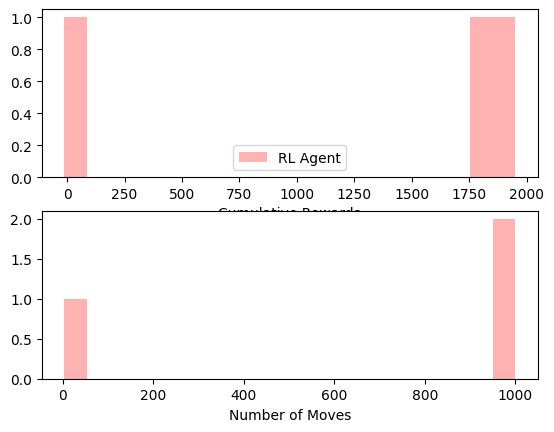

In [3]:
random_agent_cumulative_scores = np.array(random_agent_cumulative_scores)
max_agent_cumulative_scores = np.array(max_agent_cumulative_scores)
ssv_agent_cumulative_scores = np.array(ssv_agent_cumulative_scores)
center_agent_cumulative_scores = np.array(center_agent_cumulative_scores)

random_agent_nmoves = np.array(random_agent_nmoves)
max_agent_nmoves = np.array(max_agent_nmoves)
ssv_agent_nmoves = np.array(ssv_agent_nmoves)
center_agent_nmoves = np.array(center_agent_nmoves)

quantiles = [0.01, 0.5, 0.99]
random_agent_cumulative_scores_quantiles = np.quantile(random_agent_cumulative_scores, quantiles)
max_agent_cumulative_scores_quantiles = np.quantile(max_agent_cumulative_scores, quantiles)
ssv_agent_cumulative_scores_quantiles = np.quantile(ssv_agent_cumulative_scores, quantiles)
center_agent_cumulative_scores_quantiles = np.quantile(center_agent_cumulative_scores, quantiles)

random_agent_nmoves_quantiles = np.quantile(random_agent_nmoves, quantiles)
max_agent_nmoves_quantiles = np.quantile(max_agent_nmoves, quantiles)
ssv_agent_nmoves_quantiles = np.quantile(ssv_agent_nmoves, quantiles)
center_agent_nmoves_quantiles = np.quantile(center_agent_nmoves, quantiles)

print('Random Agent')
print('Cumulative Score Quantiles: ', random_agent_cumulative_scores_quantiles)
print('N Moves Quantiles: ', random_agent_nmoves_quantiles)

print()
print('Max Agent')
print('Cumulative Score Quantiles: ', max_agent_cumulative_scores_quantiles)
print('N Moves Quantiles: ', max_agent_nmoves_quantiles)

print()
print('SSV Agent')
print('Cumulative Score Quantiles: ', ssv_agent_cumulative_scores_quantiles)
print('N Moves Quantiles: ', ssv_agent_nmoves_quantiles)

print()
print('Center Agent')
print('Cumulative Score Quantiles: ', center_agent_cumulative_scores_quantiles)
print('N Moves Quantiles: ', center_agent_nmoves_quantiles)

n_bins = 20
fig_rewards, axs_rewards = plt.subplots(2,1, figsize=(6,10))
# axs_rewards[0].hist(np.log10(random_agent_cumulative_scores),color='r',label='Random Agent',alpha=0.3,bins=n_bins)
# axs_rewards[0].hist(np.log10(max_agent_cumulative_scores),color='b',label='Max Agent',alpha=0.3,bins=n_bins)
# # axs_rewards[0].hist(np.log10(ssv_agent_cumulative_scores),color='g',label='SSV Agent',alpha=0.3,bins=n_bins)
# axs_rewards[0].hist(np.log10(center_agent_cumulative_scores),color='k',label='Center Agent',alpha=0.3,bins=n_bins)

# axs_rewards[0].legend()
# axs_rewards[0].set_xlabel('Cumulative Rewards')

# axs_rewards[1].hist(np.log10(random_agent_nmoves),color='r',label='Random Agent',alpha=0.3,bins=n_bins)
# axs_rewards[1].hist(np.log10(max_agent_nmoves),color='b',label='Max Agent',alpha=0.3,bins=n_bins)
# # axs_rewards[1].hist(np.log10(ssv_agent_nmoves),color='g',label='SSV Agent',alpha=0.3,bins=n_bins)
# axs_rewards[1].hist(np.log10(center_agent_nmoves),color='k',label='Center Agent',alpha=0.3,bins=n_bins)


axs_rewards[0].hist(random_agent_cumulative_scores,color='r',label='Random Agent',alpha=0.3,bins=n_bins)
axs_rewards[0].hist(max_agent_cumulative_scores,color='b',label='Max Agent',alpha=0.3,bins=n_bins)
axs_rewards[0].hist(ssv_agent_cumulative_scores,color='g',label='SSV Agent',alpha=0.3,bins=n_bins)
axs_rewards[0].hist(center_agent_cumulative_scores,color='k',label='Center Agent',alpha=0.3,bins=n_bins)

axs_rewards[0].legend()
axs_rewards[0].set_xlabel('Cumulative Rewards')

axs_rewards[1].hist(random_agent_nmoves,color='r',label='Random Agent',alpha=0.3,bins=n_bins)
axs_rewards[1].hist(max_agent_nmoves,color='b',label='Max Agent',alpha=0.3,bins=n_bins)
axs_rewards[1].hist(ssv_agent_nmoves,color='g',label='SSV Agent',alpha=0.3,bins=n_bins)
axs_rewards[1].hist(center_agent_nmoves,color='k',label='Center Agent',alpha=0.3,bins=n_bins)


axs_rewards[1].set_xlabel('Number of Moves')

plt.show()


